# Evaluation of Models For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *MM/DD/20YY*
***
**Description:**
Notebook to evaluate a model on test data
***
**TODOs:**
 - <font color='red'> Generate tiled seqs 66bp windows ohe --> going to involve going back into each dataset and building .npy objects and then compiling </font>
 - <font color='red'> Perform a feature importance analysis of some kind of microscope seqs? </font>
***

# Set-up

In [207]:
# Classics
import os
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

# For stats
from scipy import stats

# Load local libraries
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
sys.path.append('/cellar/users/aklie/projects/EUGENE/NN/')
sys.path.append('/cellar/users/aklie/bin/make_it_train/')
import project_utils
import otx_enhancer_utils

# Deep learning time
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

# Check for GPU
print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))
    print("Running on {} devices".format(torch.cuda.device_count()))

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

Using a GPU? True
Device number [0-7]: 0
Running on 1 devices


In [212]:
# Data params
TRAIN_DATASET = "2021_OLS_Library"
FEATURES = "ohe-seq"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.09-0.4"  # Preprocessing steps, separated by "-"
SPLIT = 0.9
SUBSET = False

In [213]:
# Architecture params
HYPERPARAM = "baseline"
ARCHITECTURE = "EUGENE_biLSTM"
BATCH_SIZE=256
TUNE = False
EPOCHS_TRAINED = 33
PATIENCE = 3
BIDIRECTIONAL = True
RECURRENT = True

In [214]:
# Out directory
OUTDIR="{}_{}_{}_{}".format(PREPROCESS, FEATURES, HYPERPARAM, ARCHITECTURE)
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

# Load model

In [216]:
if ARCHITECTURE == "lstm":
    print("Loading a lstm RNN model")
    from models import lstm
    #eugene = lstm(bidirectional=True, hidden_size=64, num_layers=3)
    eugene = lstm()
elif ARCHITECTURE == "EUGENE_biLSTM":
    print("Loading a EUGENE_biLSTM RNN model")
    from models import EUGENE_biLSTM
    eugene = EUGENE_biLSTM()
elif ARCHITECTURE == "EUGENE":
    print("Loading a EUGENE CNN model")
    from models import EUGENE
    eugene = EUGENE()
elif ARCHITECTURE == "DeepSea":
    print("Loading a DeepSea CNN model")
    from models import DeepSea
    eugene = DeepSea()
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on:", device)
print("Loading previous model at {}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE),)
eugene.load_state_dict(torch.load("{}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE), map_location=torch.device(device)))
eugene.to(device)
eugene.eval()

Loading a EUGENE_biLSTM RNN model
Executing the model on: cuda
Loading previous model at 0.09-0.4_ohe-seq_baseline_EUGENE_biLSTM/0.09-0.4_ohe-seq_baseline_33-clf_EUGENE_biLSTM.pt


EUGENE_biLSTM(
  (lstm): LSTM(4, 32, batch_first=True)
  (reverse_lstm): LSTM(4, 32, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [217]:
# Load training dataframe
OLS_dataset = pd.read_csv("../data/2021_OLS_Library/2021_OLS_Library.tsv", sep="\t")
OLS_dataset.head(1)

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NAME,SEQ,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA,SEQ_LEN,linker_1,TFBS_1,linker_2,TFBS_2,linker_3,TFBS_3,linker_4,TFBS_4,linker_5,TFBS_5,linker_6
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767,66,S1,G1R,S2,E1F,S3,E2F,S4,G2R,S5,G3F,S6


# Load testing data and build dataloaders

## Validation set

In [226]:
# Load validation into a dataloader
X_val = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}.npy'.format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
y_val = np.loadtxt('../data/{0}/{1}/{2}_y-test-{3}_{1}.txt'.format(TRAIN_DATASET, LABELS, PREPROCESS, round(1-SPLIT, 1)), dtype=int)
id_val = np.loadtxt("../data/{}/id/{}_id-test-{}.txt".format(TRAIN_DATASET, PREPROCESS, round(1-SPLIT, 1)), dtype=str)
if not RECURRENT:
    X_val = np.transpose(X_val, axes=(0, 2, 1))
    
if BIDIRECTIONAL:
    print("Testing bidirectional model, loading reverse seqs")
    X_val_rev = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}-rev.npy'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))  
    val_dataset = TensorDataset(torch.from_numpy(np.stack([X_val, X_val_rev], axis=3)), torch.from_numpy(y_val))   
else:
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset), val_loader.dataset[0][0].shape))

Testing bidirectional model, loading reverse seqs
Dimensions of validation set: 19755 x torch.Size([66, 4, 2])


# Holdout set

In [229]:
X_holdout = np.load("../data/{}/{}/{}_X-holdout_{}.npy".format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, FEATURES))
id_holdout = np.loadtxt("../data/{}/id/{}_id-holdout.txt".format(TRAIN_DATASET, PREPROCESS), dtype=str)
if not RECURRENT:
    X_holdout = np.transpose(X_holdout, axes=(0, 2, 1))
if BIDIRECTIONAL:
    print("Testing bidirectional model, loading reverse seqs")
    X_holdout_rev = np.load("../data/{}/{}/{}_X-holdout_{}-rev.npy".format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, FEATURES))
    holdout_dataset = TensorDataset(torch.from_numpy(np.stack([X_holdout, X_holdout_rev], axis=3)),torch.empty(size=(len(X_holdout), 1)))   
else:
    holdout_dataset = TensorDataset(torch.from_numpy(X_holdout), torch.empty(size=(len(X_holdout), 1)))
    
holdout_loader = DataLoader(holdout_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Dimensions of heldout set: {} x {}".format(len(holdout_loader.dataset), holdout_loader.dataset[0][0].shape))

Testing bidirectional model, loading reverse seqs
Dimensions of heldout set: 263252 x torch.Size([66, 4, 2])


# Full genomic seqs (only applicable to an RNN)

In [232]:
# Need to save tiled ohe
X_genomic = np.load("../data/All_Genomic_Sequences/ohe_seq/X_ohe-seq.npy", allow_pickle=True)
if BIDIRECTIONAL:
    print("Testing bidirectional model, loading reverse seqs")
    X_genomic_rev = np.load("../data/All_Genomic_Sequences/ohe_seq/X_ohe-seq-rev.npy", allow_pickle=True)
y_genomic = np.loadtxt("../data/All_Genomic_Sequences/{0}/y-tiled_{0}.txt".format(LABELS))
id_genomic = np.loadtxt("../data/All_Genomic_Sequences/id/id-tiled.txt", dtype=str)

Testing bidirectional model, loading reverse seqs


## Tiled genomic sequences

In [221]:
# Load genomic sequences
X_genomic = np.load("../data/All_Genomic_Sequences/mixed/{}_{}-split_X-test_{}-tiled.npy".format(PREPROCESS, SPLIT, FEATURES))
y_genomic = np.loadtxt("../data/All_Genomic_Sequences/{0}/y-tiled_{0}.txt".format(LABELS))
id_genomic = np.loadtxt("../data/All_Genomic_Sequences/id/id-tiled.txt", dtype=str)
valid_idx = np.loadtxt("../data/All_Genomic_Sequences/mixed/id-valid-tiled.txt", dtype=str)
valid_indices = np.where(np.in1d(id_genomic, valid_idx))[0]
genomic_dataset = pd.read_csv("../data/All_Genomic_Sequences/All_Genomic_Sequences-tiled.tsv", sep="\t").loc[valid_indices]

# Make predictions on sequences
y_genomic_preds = clf.predict(X_genomic)
y_genomic_probs = clf.predict_proba(X_genomic)[:, 1]
genomic_dataset["PREDS"] = y_genomic_preds
genomic_dataset["SCORES"] = y_genomic_probs

# Set data variable
data = genomic_dataset[genomic_dataset["TILE"].str.lower() != "full"]

FileNotFoundError: [Errno 2] No such file or directory: '../data/All_Genomic_Sequences/mixed/0.09-0.4_0.9-split_X-test_ohe-seq-tiled.npy'

## Get predictions

In [231]:
# Get the best model results
prob_thresh = 0.5
dataloaders = {"validation": val_loader, "holdout": holdout_loader}
y_outputs = {'validation': torch.empty(size=(len(X_val), 1)), 
             'holdout': torch.empty(size=(len(X_holdout), 1)),
             'full_genomic': torch.empty(size=(sum([len(dataset) for dataset in X_genomic]), 1))}
y_targets = {}
for phase in ['validation', 'holdout']:
    len_set = len(dataloaders[phase].dataset)
    for batch, (inputs, _) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        if BIDIRECTIONAL:
            input_forward = inputs[:, :, :, 0].to(device)
            input_reverse = inputs[:, :, :, 1].to(device)
            outputs = eugene(input_forward.float(), input_reverse.float()).detach()
        else:
            inputs = inputs.to(device)
            outputs = eugene(inputs.float()).detach()
        if BATCH_SIZE*(batch+1) < len_set:
            y_outputs[phase][BATCH_SIZE*batch:BATCH_SIZE*(batch+1)] = outputs
        else:
            y_outputs[phase][BATCH_SIZE*batch:len_set] = outputs

In [236]:
X_genomic_rev[0][0].shape

(194, 4)

In [240]:
# Have to do it this way for genomic because they are all different sizes
i = 0
for i_dataset, dataset in enumerate(X_genomic):
    for i_input, inputs in enumerate(dataset):
        inputs = torch.unsqueeze(torch.tensor(inputs), dim=0).float().to(device)
        if BIDIRECTIONAL:
            input_forward = inputs
            input_reverse = torch.unsqueeze(torch.tensor(X_genomic_rev[i_dataset][i_input]), dim=0).float().to(device)
            outputs = eugene(input_forward.float(), input_reverse.float()).detach()
        else:
            inputs = inputs.to(device)
            outputs = eugene(inputs.float()).detach()
        y_outputs["full_genomic"][i] = outputs
        i+=1

In [247]:
# Compile predictions on val
y_val_outs = y_outputs["validation"]
y_val_probs = torch.sigmoid(y_val_outs).detach().numpy().squeeze()
y_val_preds = (y_val_probs >= prob_thresh).astype(int)
clf_val_df = pd.DataFrame(data={"NAME": id_val, "PREDS": y_val_preds, "SCORES": y_val_probs})
val_df = pd.merge(OLS_dataset, clf_val_df, on="NAME")

In [248]:
# Compile predictions on holdout
y_holdout_outs = y_outputs["holdout"]
y_holdout_probs = torch.sigmoid(y_holdout_outs).detach().numpy().squeeze()
y_holdout_preds = (y_holdout_probs >= prob_thresh).astype(int)
clf_holdout_df = pd.DataFrame(data={"NAME": id_holdout, "PREDS": y_holdout_preds, "SCORES": y_holdout_probs})
holdout_df = pd.merge(OLS_dataset, clf_holdout_df, on="NAME")

In [249]:
# Compile predictions on full genomic
y_full_genomic_outs = y_outputs["full_genomic"]
y_full_genomic_probs = torch.sigmoid(y_full_genomic_outs).detach().numpy().squeeze()
y_full_genomic_preds = (y_full_genomic_probs >= prob_thresh).astype(int)
genomic_dataset = pd.read_csv("../data/All_Genomic_Sequences/All_Genomic_Sequences.tsv", sep="\t")
genomic_dataset["PREDS"] = y_full_genomic_preds
genomic_dataset["SCORES"] = y_full_genomic_probs

# Evaluate on validation sequences

In [250]:
# Set data to be val
data = val_df

## <u> **Confusion matrix** </u>

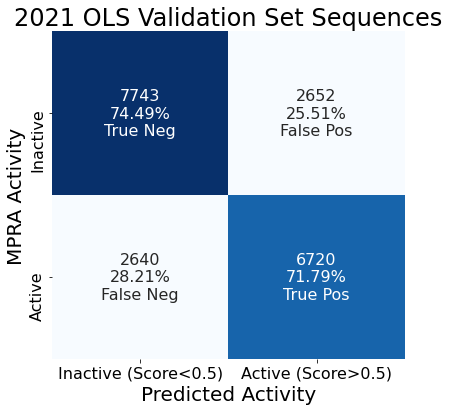

In [251]:
project_utils.cf_plot_from_df(data, label_col="MPRA_FXN", title="2021 OLS Validation Set Sequences", ylab="MPRA Activity")

## <u> **Correlation w/ activity** </u>

0.5390872268651663 0.0


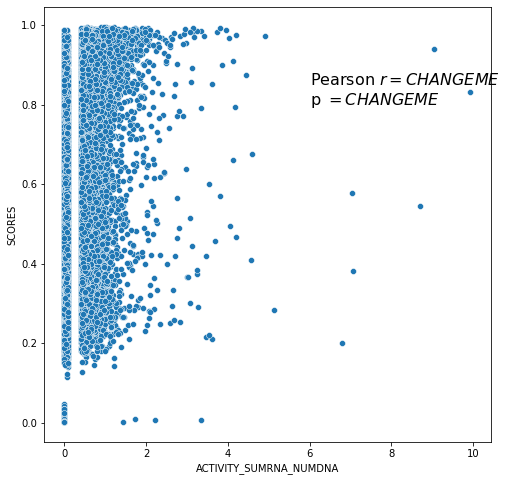

In [252]:
# Plot scatter
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#sns.regplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", x_jitter=.5, ax=ax)
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", ax=ax)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["SCORES"])
print(r, p)
ax.annotate(r'Pearson $r = CHANGE ME$' + '\n' + r'p $=CHANGE ME$', (6, 0.8), fontsize=16);

## <u> **Threshold plot** </u>

10it [00:00, 21.11it/s]


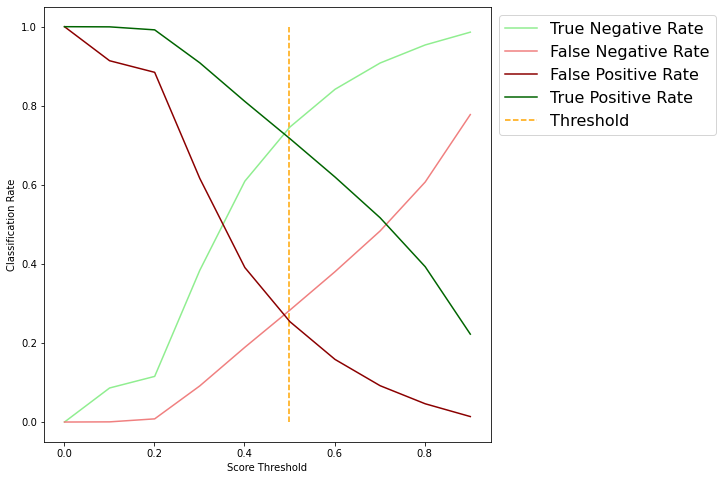

In [253]:
project_utils.threshold_plot(data, label_col="MPRA_FXN")

## <u> **Score distribution plot** </u>

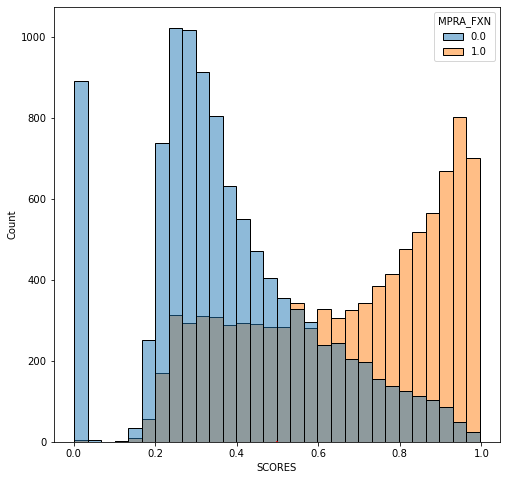

In [254]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.histplot(data=data, x="SCORES", hue="MPRA_FXN", ax=ax);
ax.vlines(0.5, 0, 1, color="red", linestyle="dashed", label="Threshold");

# Evaluate on holdout sequences

## Microscope sequences

In [255]:
microscope_mask = (~holdout_df["MICROSCOPE_FXN"].isna())
microscope_df = holdout_df[microscope_mask]
microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)
data = microscope_df
microscope_colors = dict(zip(data["MICROSCOPE_FXN"].unique(), ["darkgreen", "lightgreen", "gold", "red"]))
data["microscope_label"].value_counts()

<ipython-input-255-764356113563>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)


1    52
0    26
Name: microscope_label, dtype: int64

### <u> **Confusion matrix** </u>

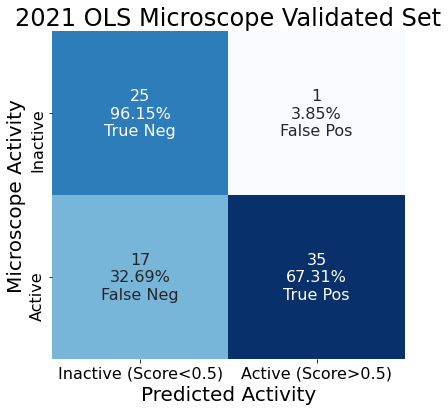

In [256]:
project_utils.cf_plot_from_df(data, label_col="microscope_label", title="2021 OLS Microscope Validated Set", ylab="Microscope Activity")

### <u> **Activity boxplot grouped by function** </u>

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


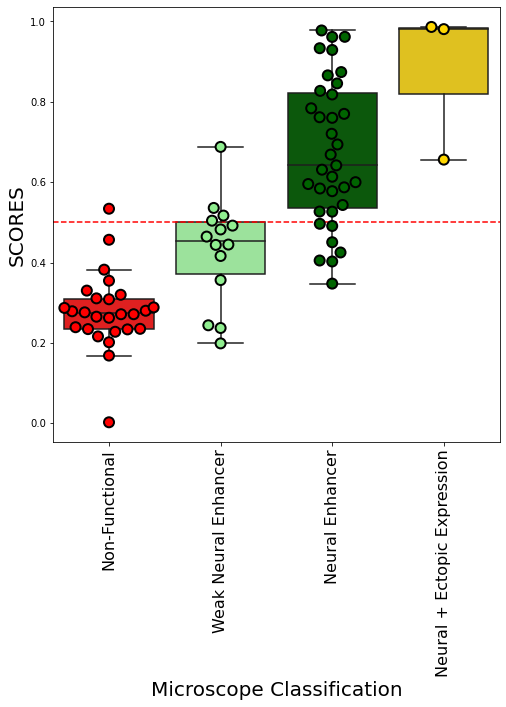

In [257]:
microscope_order = ['Non-Functional', 'Weak Neural Enhancer', 'Neural Enhancer', 'Neural + Ectopic Expression']
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.boxplot(y=data["SCORES"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, ax=ax)
sns.swarmplot(y=data["SCORES"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, size=10, edgecolor="black", linewidth=2, ax=ax)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16);
ax.set_xlabel("Microscope Classification", fontsize=20)
ax.set_ylabel("SCORES", fontsize=20);

### <u> **Swarmplot of scores** </u>

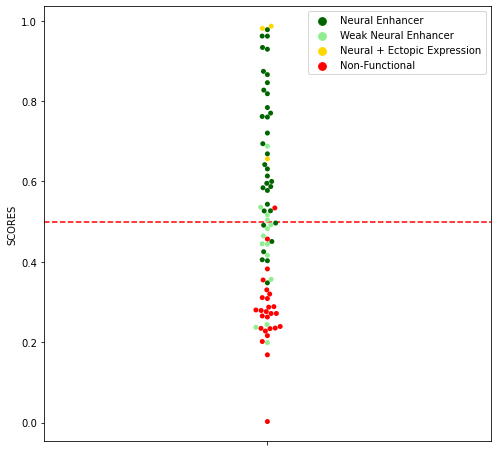

In [258]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.swarmplot(y=data["SCORES"], hue=data["MICROSCOPE_FXN"], x=[""]*len(data), palette=microscope_colors, ax=ax)
plt.legend(bbox_to_anchor=(1,1))
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");

### <u> **Scatterplot with activity** </u>

0.5915345131586822 1.1782417542640942e-08


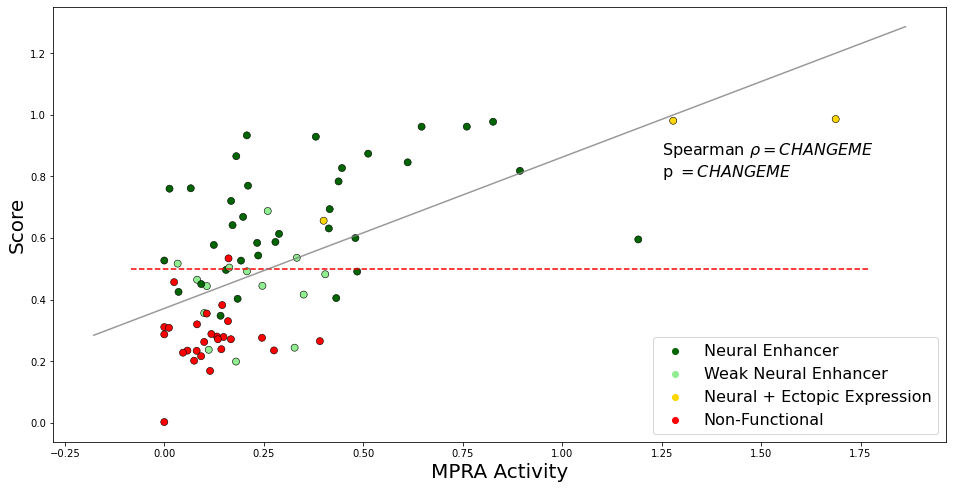

In [259]:
m, b = np.polyfit(data["ACTIVITY_SUMRNA_NUMDNA"], data["SCORES"], 1)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", hue="MICROSCOPE_FXN", palette=microscope_colors, s=50, edgecolor="black", ax=ax)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");
ax.set_xlabel("MPRA Activity", fontsize=20)
ax.set_ylabel("Score", fontsize=20);
ax.legend(title='Microscope Classification', fontsize=16)

# Add trendline
x=np.arange(ax.get_xlim()[0], ax.get_xlim()[1], 0.01)
ax.plot(x, m*x + b, '-', color = "grey", alpha=0.8)
ax.legend(loc="lower right", fontsize=16)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["SCORES"])
print(r, p)
ax.annotate(r'Spearman $\rho = CHANGE ME$' + '\n' + r'p $=CHANGEME$', (1.25, 0.8), fontsize=16);

## No label sequences

In [260]:
ambiguous_df = holdout_df[~microscope_mask]
data = ambiguous_df

0.22728819822727914 0.0


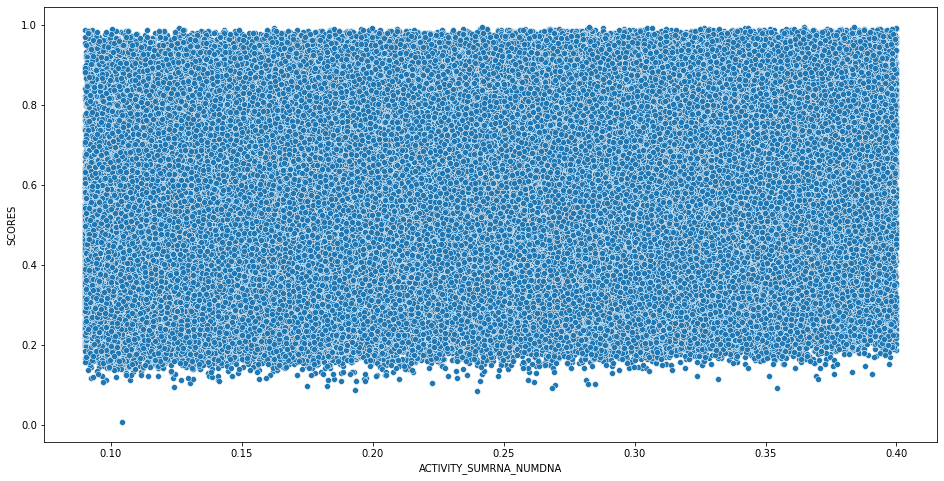

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=ambiguous_df, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", ax=ax)
no_na = (~ambiguous_df["ACTIVITY_SUMRNA_NUMDNA"].isna())
p, r = stats.pearsonr(ambiguous_df[no_na]["ACTIVITY_SUMRNA_NUMDNA"], ambiguous_df[no_na]["SCORES"])
print(p, r)

# Evaluate on genomic sequences

## Full sequences

In [262]:
# Set data variable
data = genomic_dataset

### <u> **Confusion matrix** </u>

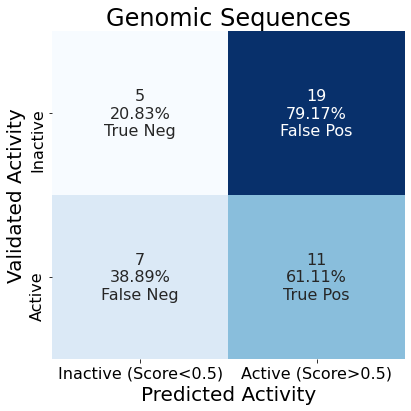

In [263]:
project_utils.cf_plot_from_df(data, title="Genomic Sequences", ylab="Validated Activity")

### <u> **Feature importances** </u>
This will probably vary significantly between model types. Below is a simple example case for linear regression

In [ ]:
#feature_names = pd.read_csv("../data/2021_OLS_Library/mixed_1.0/mixed-1.0_header.txt", header=None)[0]
#project_utils.coefficient_plot(clf, feature_names, title="{} {} {} Encoded Coefficients".format(PREPROCESS, TRAIN_DATASET, FEATURES))

## Tiled Sequences

In [ ]:
# Load genomic sequences
X_genomic = np.load("../data/All_Genomic_Sequences/mixed/{}_{}-split_X-test_{}-tiled.npy".format(PREPROCESS, SPLIT, FEATURES))
y_genomic = np.loadtxt("../data/All_Genomic_Sequences/{0}/y-tiled_{0}.txt".format(LABELS))
id_genomic = np.loadtxt("../data/All_Genomic_Sequences/id/id-tiled.txt", dtype=str)
valid_idx = np.loadtxt("../data/All_Genomic_Sequences/mixed/id-valid-tiled.txt", dtype=str)
valid_indices = np.where(np.in1d(id_genomic, valid_idx))[0]
genomic_dataset = pd.read_csv("../data/All_Genomic_Sequences/All_Genomic_Sequences-tiled.tsv", sep="\t").loc[valid_indices]

# Make predictions on sequences
y_genomic_preds = clf.predict(X_genomic)
y_genomic_probs = clf.predict_proba(X_genomic)[:, 1]
genomic_dataset["PREDS"] = y_genomic_preds
genomic_dataset["SCORES"] = y_genomic_probs

# Set data variable
data = genomic_dataset[genomic_dataset["TILE"].str.lower() != "full"]

### <u> **Tile plot** </u>

In [ ]:
otx_enhancer_utils.tile_plot(data)

### <u> **Sequence tracks** </u>

In [ ]:
cmap = mpl.cm.RdYlGn
norm = mpl.colors.Normalize(vmin=data["SCORES"].min(), vmax=data["SCORES"].max())

In [ ]:
test = data[data["NAME"] == "scaffold_48:226447:226527"]
seqs = test["SEQ"].apply(str.upper).values
names = test["NAME"].values
scores = test["SCORES"].values
otx_enhancer_utils.otxGenomeTracks(seqs[0], seq_name=names[0], model_pred=scores[0], cmap=cmap, norm=norm)
otx_enhancer_utils.defineTFBS(seqs[0])

# Scratch

# References

 1. Ref 1
 2. Ref 2